In [36]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
covid_df = pd.read_csv(url)

In [38]:
covid_df['datestamp'] = [datetime.strptime(d,'%Y-%m-%d') for d in covid_df.date]

all_countries = pd.DataFrame(index=covid_df.iso_code.unique())
cases_start_date = covid_df[(covid_df.total_cases > 10000)].groupby('iso_code').datestamp.min().to_frame()
deaths_start_date = covid_df[(covid_df.total_deaths > 100)].groupby('iso_code').datestamp.min().to_frame()
all_countries['iso_code'] = all_countries.index
all_countries['cases_start_date'] = cases_start_date
all_countries['deaths_start_date'] = deaths_start_date
covid_df = pd.merge(covid_df,all_countries,how='left',on='iso_code')
covid_df.loc[covid_df.cases_start_date.isna(),covid_df.columns=='cases_start_date'] = datetime(datetime.today().year,12,31)
covid_df.loc[covid_df.deaths_start_date.isna(),covid_df.columns=='deaths_start_date'] = datetime(datetime.today().year,12,31)

covid_df['days_since_100_deaths'] = (covid_df.datestamp - covid_df.deaths_start_date).astype(int)/(24*60*60*10e8)
covid_df['days_since_10000_cases'] = (covid_df.datestamp - covid_df.cases_start_date).astype(int)/(24*60*60*10e8)

covid_df.drop(columns = ['cases_start_date','deaths_start_date'])

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,datestamp,days_since_100_deaths,days_since_10000_cases
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,18.733,18.733,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-13,-293.0,-293.0
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,NaN,NaN,2.676,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-19,-287.0,-287.0
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,37.465,18.733,2.676,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-20,-286.0,-286.0
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,NaN,NaN,2.676,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-21,-285.0,-285.0
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,NaN,NaN,2.676,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-22,-284.0,-284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50296,NaN,NaN,International,2020-10-11,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-11,-81.0,-81.0
50297,NaN,NaN,International,2020-10-12,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-12,-80.0,-80.0
50298,NaN,NaN,International,2020-10-13,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-13,-79.0,-79.0
50299,NaN,NaN,International,2020-10-14,696.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-14,-78.0,-78.0


# Cases and deaths worldwide

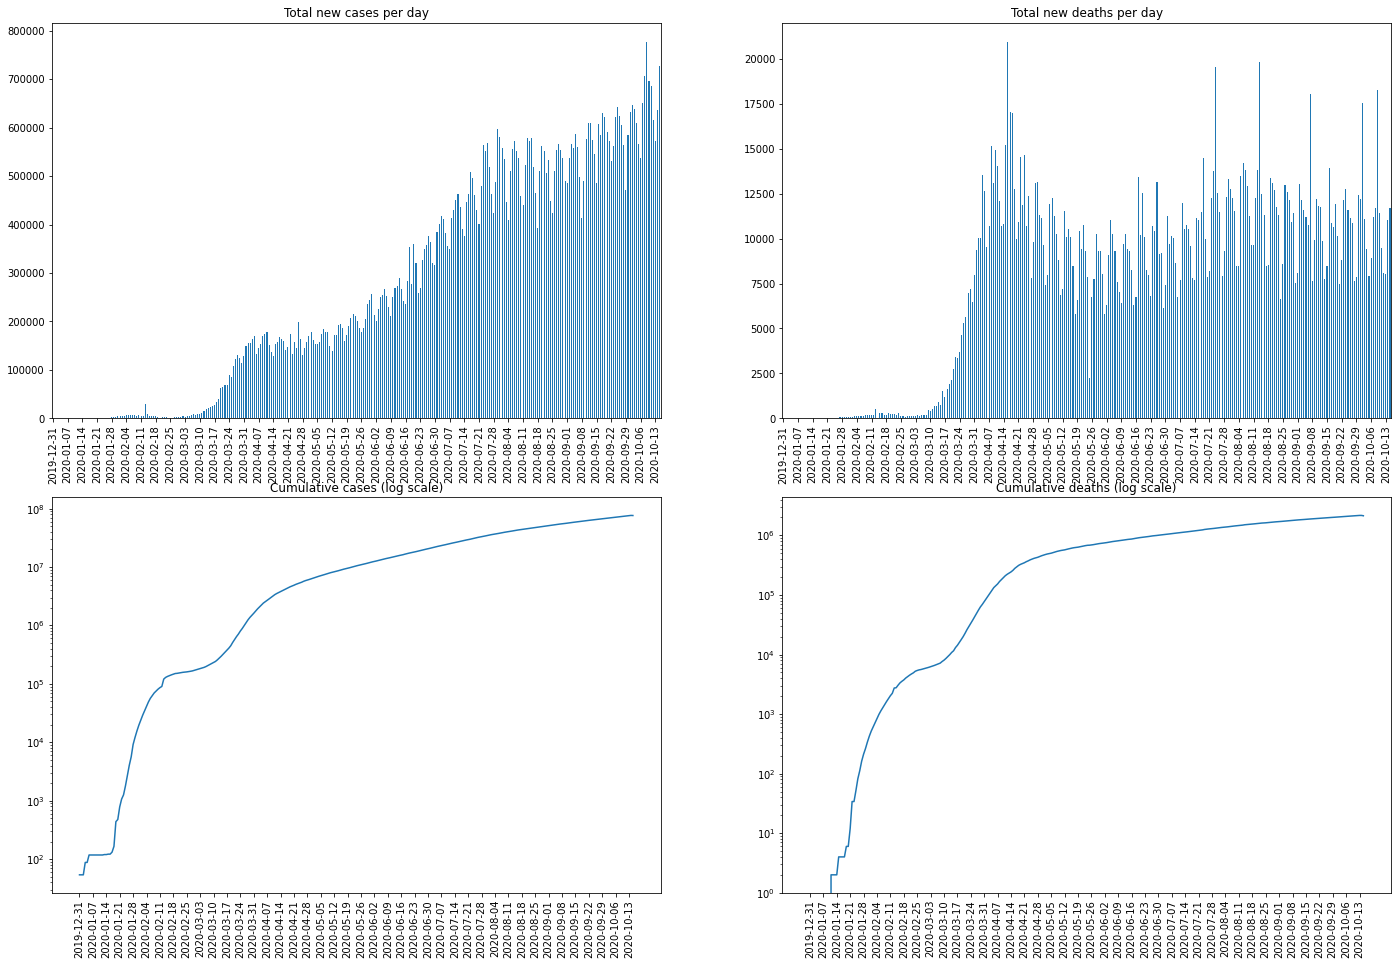

In [39]:
dates = covid_df.date.unique()
dates = np.sort(dates)
fig,axs = plt.subplots(2,2,figsize=(24,16))

covid_df.groupby('date').new_cases.sum().plot(kind='bar',title='Total new cases per day',ax=axs[0][0])
axs[0][0].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][0].xaxis.set_label_text('');
covid_df.groupby('date').new_deaths.sum().plot(kind='bar',title='Total new deaths per day',ax=axs[0][1])
axs[0][1].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][1].xaxis.set_label_text('');

covid_df.groupby('date').total_cases.sum().plot(title='Cumulative cases (log scale)',ax=axs[1][0])
axs[1][0].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90)
axs[1][0].xaxis.set_label_text('');

axs[1][0].set_yscale('log')
covid_df.groupby('date').total_deaths.sum().plot(title='Cumulative deaths (log scale)',ax=axs[1][1])
axs[1][1].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90);
axs[1][1].set_yscale('log')
axs[1][1].xaxis.set_label_text('');


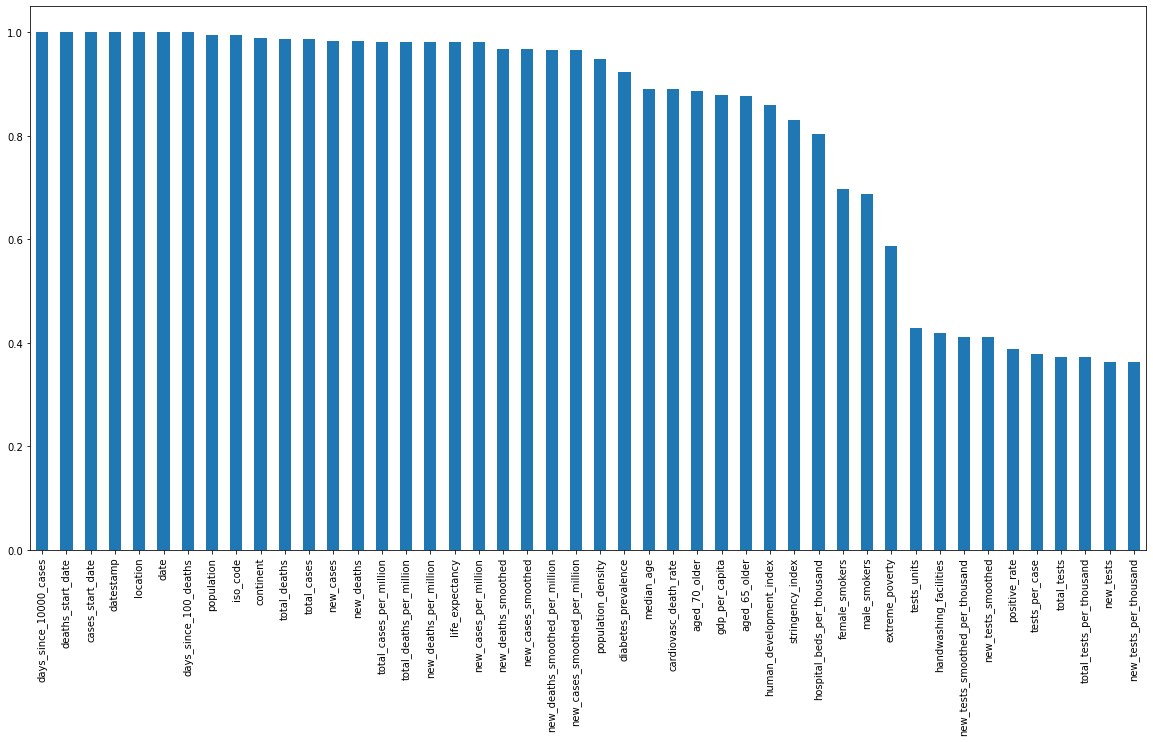

In [40]:
#'Data to do with testing is poorly reported'
column_fill_rate =  (1-covid_df.isna().sum()/covid_df.shape[0])
column_fill_rate.sort_values(ascending=False).plot(kind='bar',figsize=(20,10));

# Scatter of tests per million vs deaths per million by country

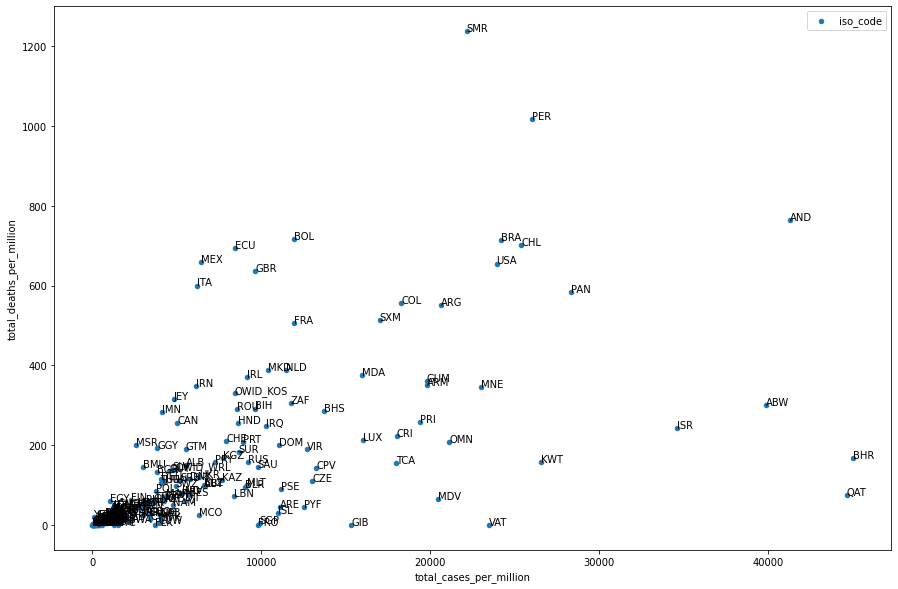

In [41]:
ax = covid_df.loc[covid_df.date == covid_df.date.max(),:].plot(x='total_cases_per_million',
                                                               y='total_deaths_per_million',
                                                               kind='scatter',
                                                               figsize=(15,10),
                                                               label='iso_code')
for r in covid_df.loc[covid_df.date == covid_df.date.max(),:].iterrows():
    ax.annotate(r[1].iso_code, (r[1].total_cases_per_million, r[1].total_deaths_per_million))


# Deaths per million by country

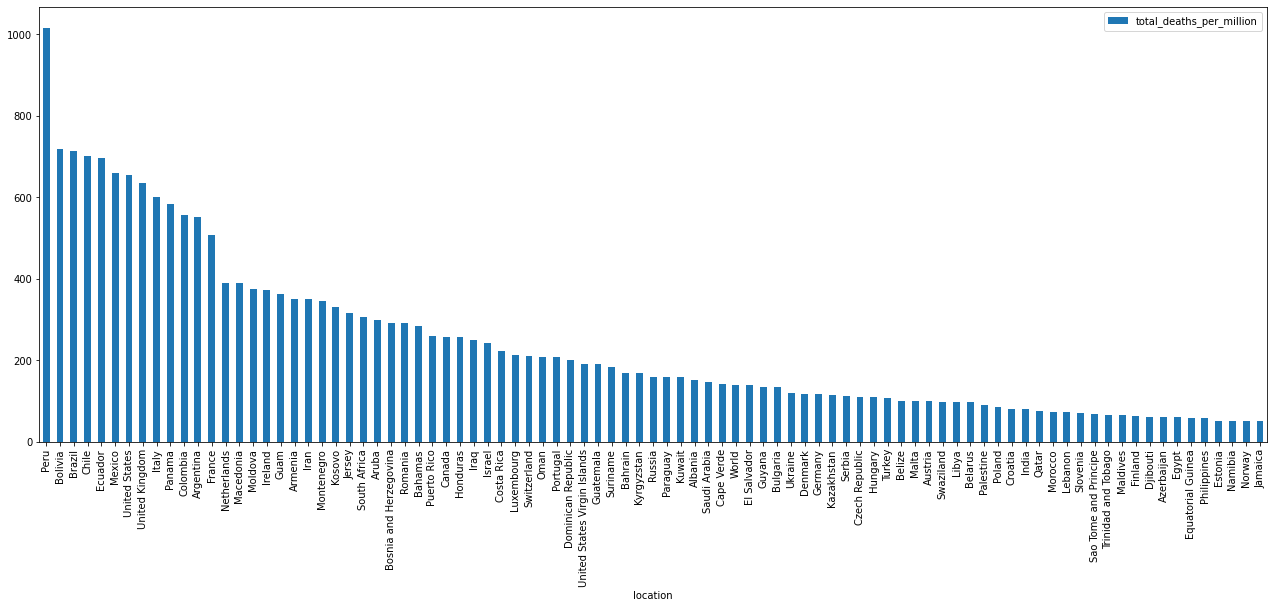

In [42]:
#covid_df.loc[covid_df.date == dates[-1],:].plot(x='iso_code',y='total_deaths_per_million',kind='bar',figsize=(22,8));
covid_df.loc[(covid_df.date == dates[-1])&(covid_df.total_deaths_per_million>50)&(covid_df.population>100000),:].sort_values('total_deaths_per_million',ascending=False).plot(
    x='location',y='total_deaths_per_million',kind='bar',figsize=(22,8));

# Deaths per case by country

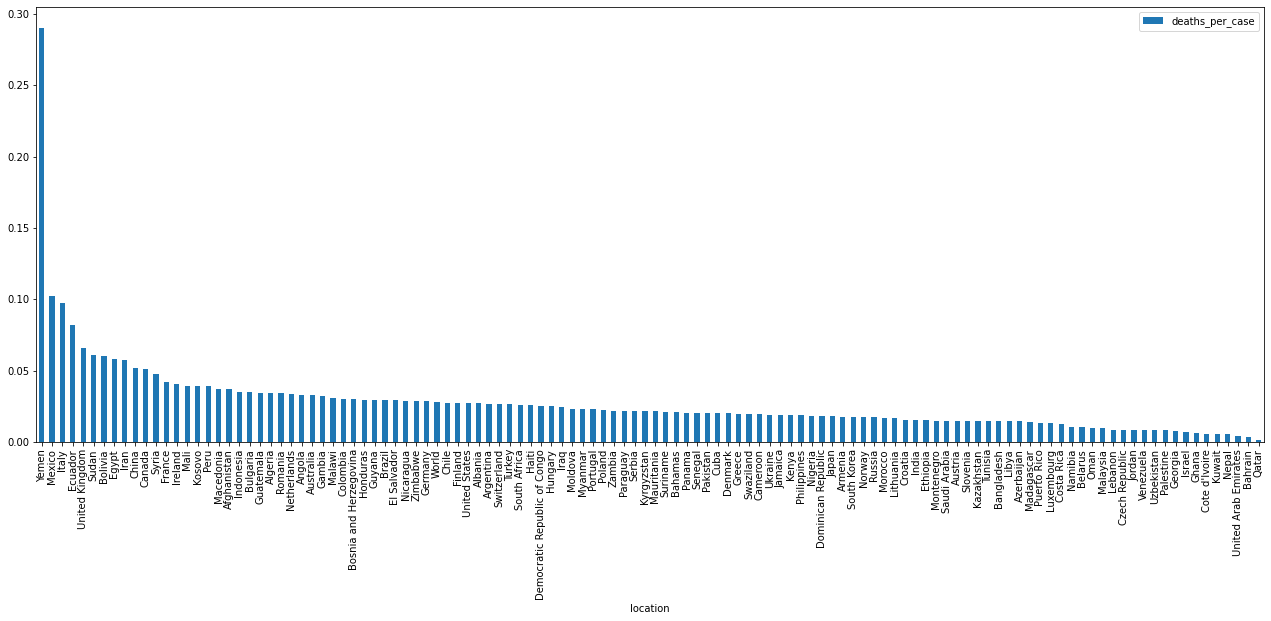

In [43]:
covid_df['deaths_per_case'] = covid_df.total_deaths_per_million/covid_df.total_cases_per_million
covid_df.loc[(covid_df.date == dates[-1])&(covid_df.population>100000)&(covid_df.total_deaths>100),:].sort_values('deaths_per_case',ascending=False).plot(
    x='location',y='deaths_per_case',kind='bar',figsize=(22,8));


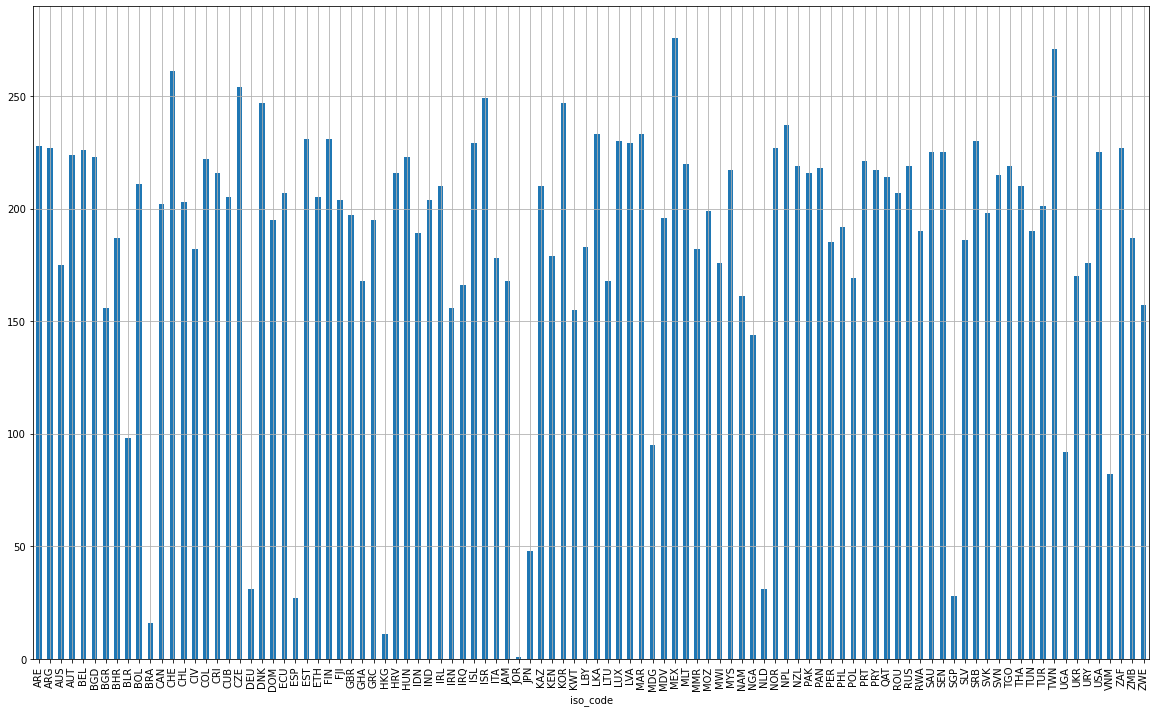

In [44]:
covid_df.loc[~covid_df.total_tests_per_thousand.isna(),:].groupby( 'iso_code').total_tests_per_thousand.count().plot(kind='bar',figsize=(20,12));

#covid_df.loc[covid_df.date==dates[-1],:].plot(x='deaths_per_case',y='total_tests_per_thousand',kind='scatter',label='iso_code')
#covid_df.loc[covid_df.date==dates[-1],['deaths_per_case','total_tests_per_thousand']]
covid_df.loc[~covid_df.total_tests_per_thousand.isna(),:].groupby( 'iso_code').datestamp.max().hist(figsize=(20,12));


# 14 day incidence rate per 100,000

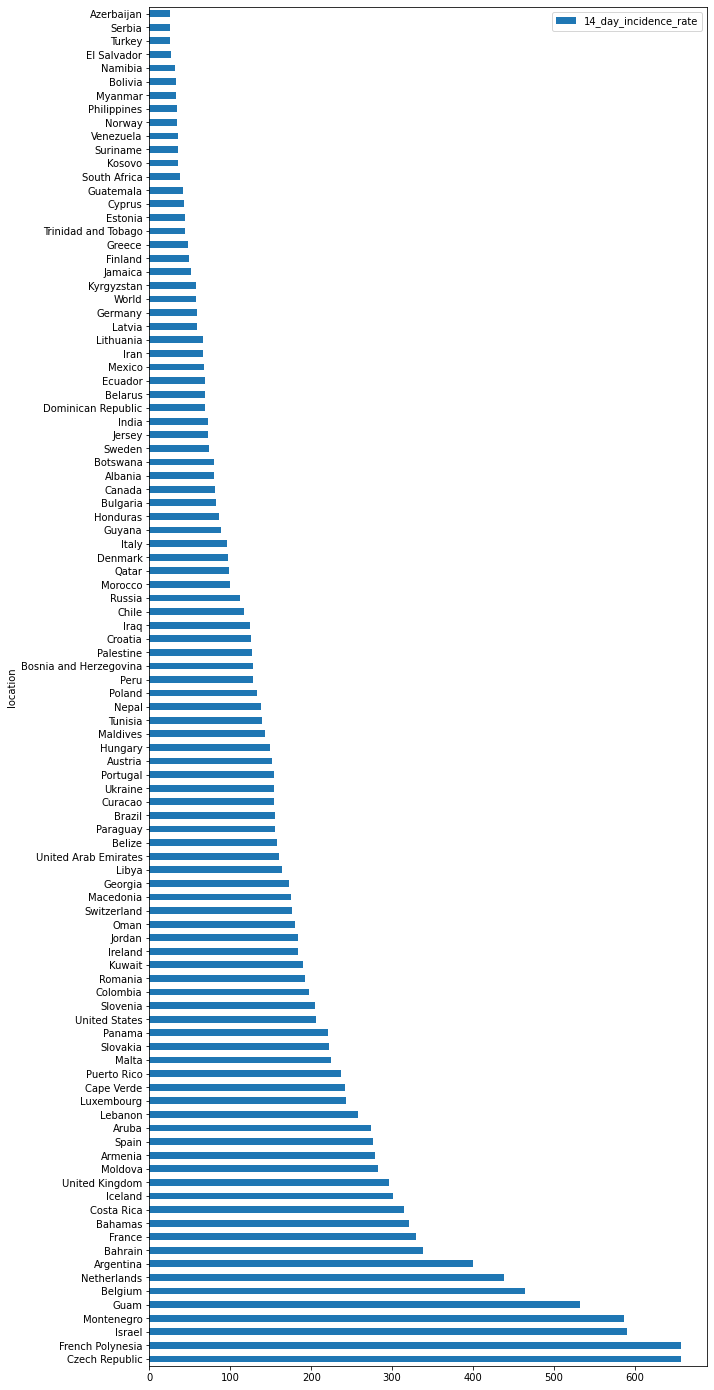

In [45]:
sorted_dates = np.sort(covid_df.datestamp.unique())
fourteen_day_incidence = covid_df[(covid_df.population > 100000) & (covid_df.datestamp.isin(sorted_dates[-14:]))].groupby('location').agg({'new_cases_per_million':'sum'})/10
fourteen_day_incidence = fourteen_day_incidence.rename(columns={'new_cases_per_million':'14_day_incidence_rate'})
fourteen_day_incidence = fourteen_day_incidence.sort_values(by='14_day_incidence_rate',ascending=False)
fig,ax = plt.subplots(figsize=(10,25));
fourteen_day_incidence[:100].plot(kind='barh',ax=ax);

# 14 day incidence rate by continent


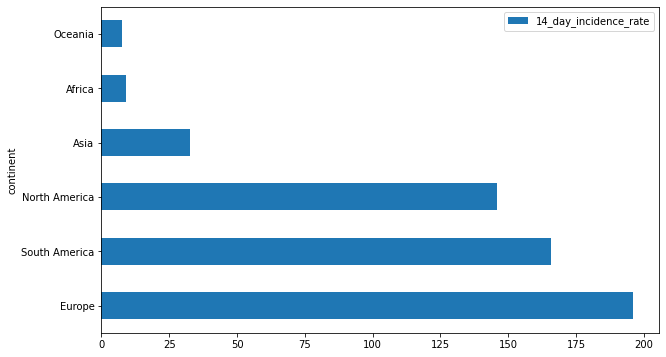

In [46]:
fourteen_day_incidence = covid_df[covid_df.datestamp.isin(sorted_dates[-14:])].groupby('continent').agg({'new_cases':'sum'})
population = covid_df[covid_df.datestamp.isin(sorted_dates[-1:])].groupby('continent').agg({'population':'sum'})
fourteen_day_incidence = pd.merge(left=fourteen_day_incidence,right=population,on='continent')
fourteen_day_incidence['14_day_incidence_rate'] = fourteen_day_incidence.new_cases/(fourteen_day_incidence.population/100000)
fourteen_day_incidence = fourteen_day_incidence.sort_values(by='14_day_incidence_rate',ascending=False)
fig,ax = plt.subplots(figsize=(10,6));
fourteen_day_incidence[:100].plot(y='14_day_incidence_rate',kind='barh',ax=ax);

# Cases and deaths single country



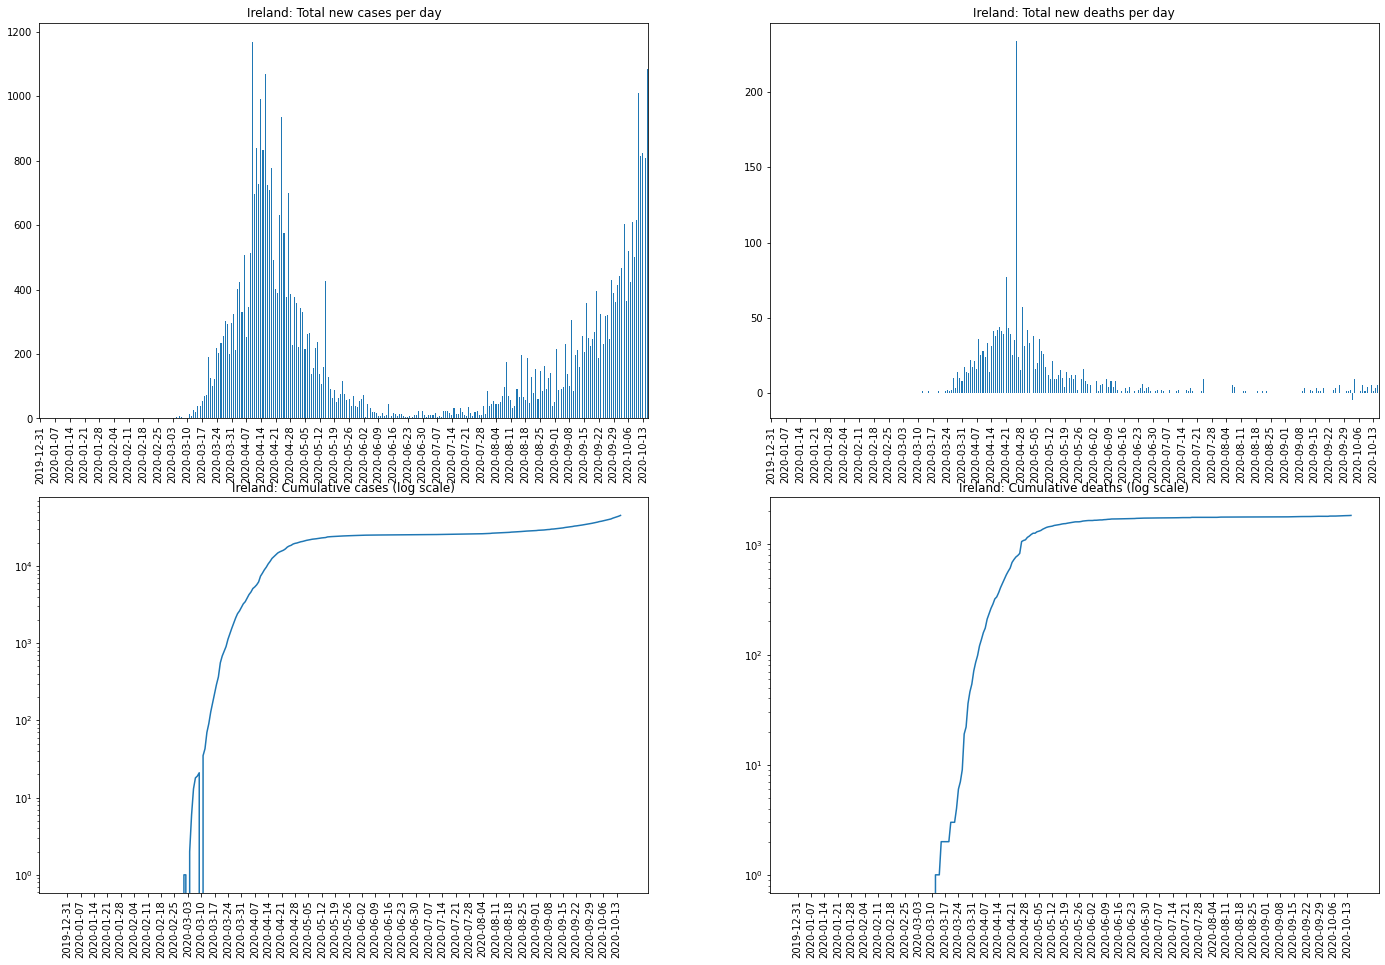

In [47]:
iso = 'IRL'
country_df = covid_df[covid_df.iso_code==iso]
country_name = country_df.location.values[0]
dates = country_df.date.unique()
dates = np.sort(dates)
fig,axs = plt.subplots(2,2,figsize=(24,16))

country_df.groupby('date').new_cases.sum().plot(kind='bar',title=country_name+': Total new cases per day',ax=axs[0][0])
axs[0][0].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][0].xaxis.set_label_text('');
country_df.groupby('date').new_deaths.sum().plot(kind='bar',title=country_name+': Total new deaths per day',ax=axs[0][1])
axs[0][1].xaxis.set_ticks(np.arange(0, len(dates), 7));axs[0][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)]);
axs[0][1].xaxis.set_label_text('');

country_df.groupby('date').total_cases.sum().plot(title=country_name+': Cumulative cases (log scale)',ax=axs[1][0])
axs[1][0].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][0].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90)
axs[1][0].set_yscale('log')
axs[1][0].xaxis.set_label_text('');
country_df.groupby('date').total_deaths.sum().plot(title=country_name+': Cumulative deaths (log scale)',ax=axs[1][1])
axs[1][1].xaxis.set_ticks(np.arange(0, len(dates), 7));
axs[1][1].xaxis.set_ticklabels(dates[np.arange(0, len(dates), 7)],rotation=90);
axs[1][1].set_yscale('log')
axs[1][1].xaxis.set_label_text('');


# Comparing the evolution in multiple countries




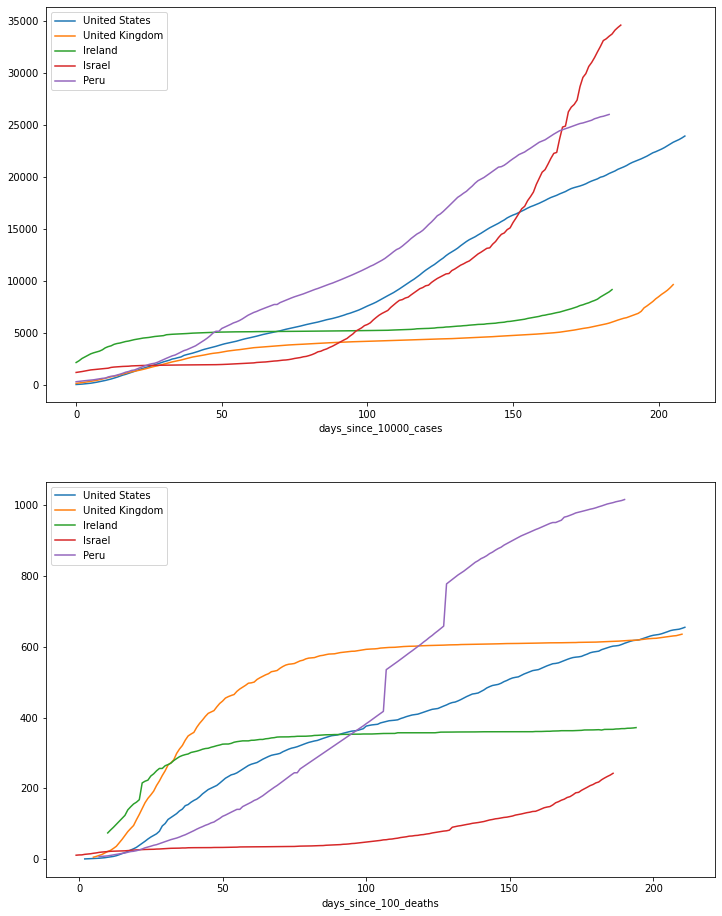

In [48]:
iso_list = ['USA','GBR','IRL','ISR','PER']
loc_list = [covid_df[covid_df.iso_code == i].location.values[0] for i in iso_list]
cases_df = covid_df[(covid_df.iso_code.isin(iso_list))&(covid_df.days_since_10000_cases>=0)]
cases_plot_data = cases_df.groupby(['location','days_since_10000_cases']).total_cases_per_million.min()
deaths_df = covid_df[(covid_df.iso_code.isin(iso_list))&(covid_df.days_since_100_deaths>=0)]
deaths_plot_data = cases_df.groupby(['location','days_since_100_deaths']).total_deaths_per_million.min()
fig,axs = plt.subplots(2,1,figsize=(12,16))
for l in loc_list:
  cases_plot_data[l].plot(ax=axs[0]);
axs[0].legend(loc_list);
for l in loc_list:
  deaths_plot_data[l].plot(ax=axs[1]);
axs[1].legend(loc_list);

# Positive test rates


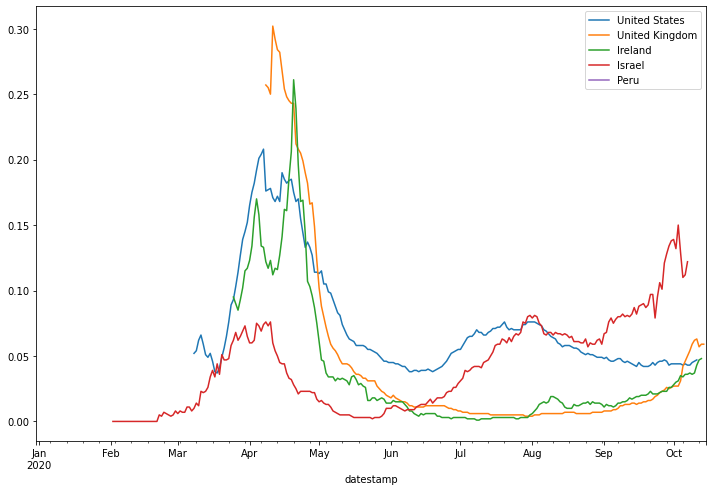

In [49]:
iso_list = ['USA','GBR','IRL','ISR','PER']
loc_list = [covid_df[covid_df.iso_code == i].location.values[0] for i in iso_list]
pos_rate_df =  covid_df[covid_df.iso_code.isin(iso_list)].groupby([
    'location','datestamp']).positive_rate.max()

fig,ax = plt.subplots(1,1,figsize=(12,8))
for l in loc_list:
  pos_rate_df[l].plot(ax=ax);
ax.legend(loc_list);

# Evolution by continent


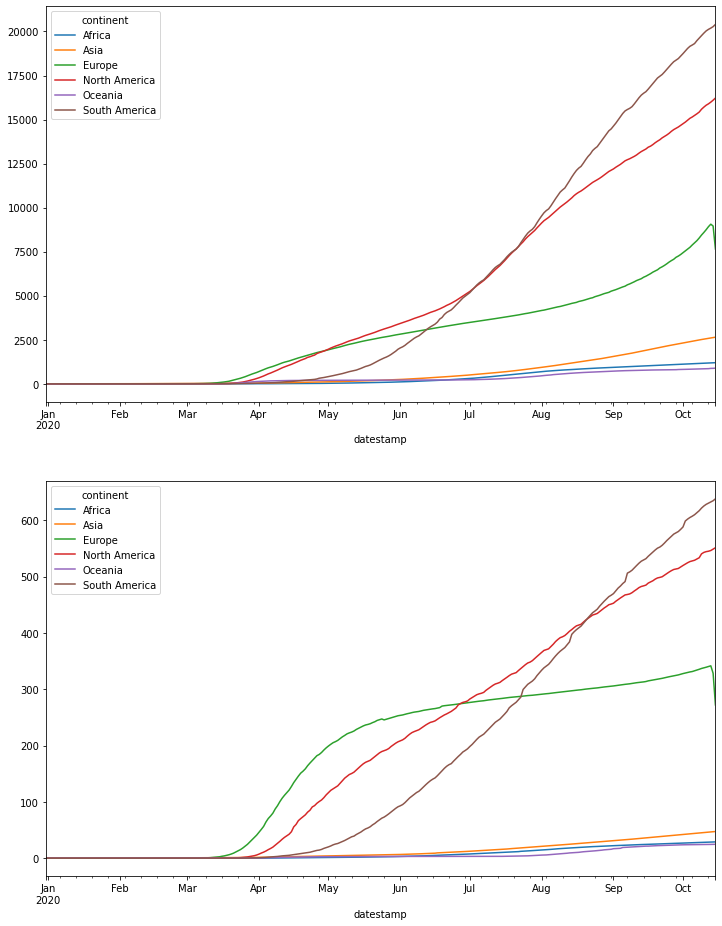

In [50]:
continent_df = covid_df.groupby(['continent','datestamp']).agg({'total_cases':'sum','total_deaths':'sum'}).unstack()
fig,axs = plt.subplots(2,1,figsize=(12,16))
for c in population.index:
  (continent_df.loc[continent_df.index==c,'total_cases'].transpose()/
    population.loc[c].population*1000000).plot(ax=axs[0])
  (continent_df.loc[continent_df.index==c,'total_deaths'].transpose()/
    population.loc[c].population*1000000).plot(ax=axs[1])
